# HOTEL BOOKING CANCELLATIONS

This is an attempt to understand the hotel demand dataset and predict cancellations. We hope to help the hotel owners to realize the true expected demand in a time period and that could help them to plan their supplies and set overbooking limits.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!pip install catboost
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
from sklearn.model_selection import train_test_split
import datetime
from datetime import timedelta
from sklearn.utils import resample
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.metrics import confusion_matrix,classification_report,recall_score,roc_auc_score,auc, confusion_matrix, roc_curve,accuracy_score
import sklearn 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV
import catboost as catboost
from catboost import CatBoostClassifier, Pool, cv
from catboost.utils import get_roc_curve
os.chdir("/content/gdrive/Shared drives/Pricing Project")

# Loading the Data


In [0]:
hotel_df = pd.read_csv("hotel_bookings.csv")
hotel_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [0]:
hotel_df.shape

(119390, 32)

# Data Preprocessing

###Missing Values

In [0]:
# % of missing values
perc_null=((hotel_df.isnull().sum()/hotel_df.shape[0])*100).sort_values(ascending=False)
perc_null

company                           94.306893
agent                             13.686238
country                            0.408744
children                           0.003350
lead_time                          0.000000
arrival_date_year                  0.000000
arrival_date_month                 0.000000
arrival_date_week_number           0.000000
is_canceled                        0.000000
market_segment                     0.000000
arrival_date_day_of_month          0.000000
stays_in_weekend_nights            0.000000
stays_in_week_nights               0.000000
adults                             0.000000
babies                             0.000000
meal                               0.000000
reservation_status_date            0.000000
distribution_channel               0.000000
reservation_status                 0.000000
is_repeated_guest                  0.000000
previous_cancellations             0.000000
previous_bookings_not_canceled     0.000000
reserved_room_type              

In [0]:
#Agent and Company are ID columns and have a lot of missing values. 
#So, let's drop them.

hotel_df =  hotel_df.drop(['agent','company'],axis = 1)

###Correlations

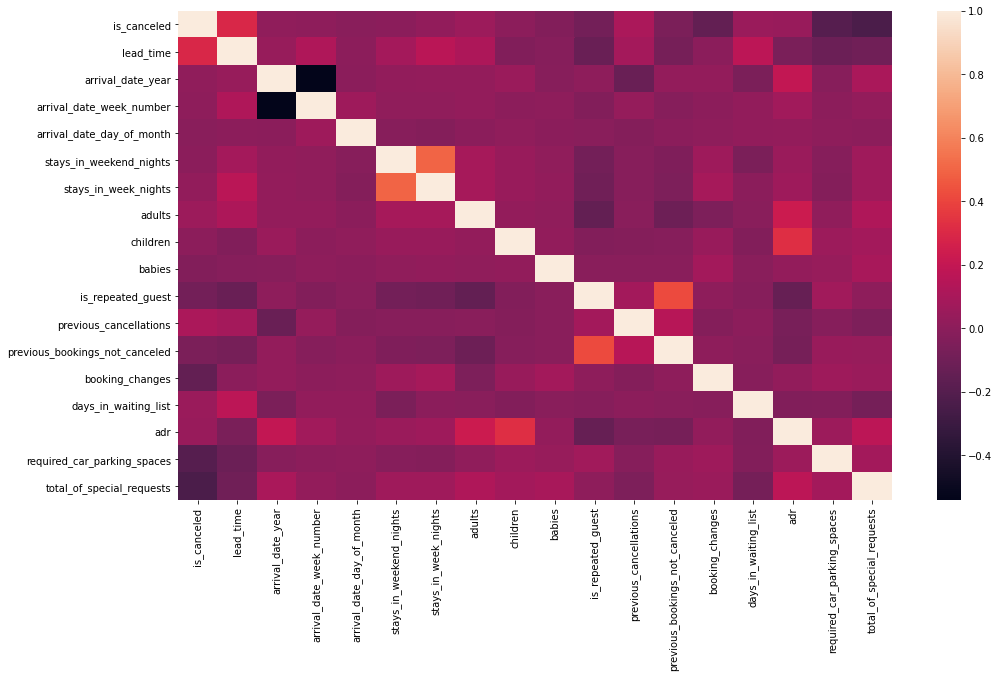

In [0]:
plt.figure(figsize=(16, 9)) 
corr_matrix = hotel_df.corr()
sns.heatmap(corr_matrix)
plt.show()

In [0]:
#Which numerical features are correlated with the label?
corr_with_cancel = corr_matrix["is_canceled"]
corr_with_cancel.abs().sort_values(ascending=False)[1:]

lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

# MISSING VALUE IMPUTATION IN TRAIN AND TEST

Before Imputing missing values, splitting into Train and test to avoid data leakage.

In [0]:
X_train, X_test = train_test_split(hotel_df, test_size = 0.30, random_state = 42)
X_train.shape, X_test.shape

((83573, 30), (35817, 30))

In [0]:
# needs to be done for test and train separately
def imputation(df):
  df["country"]=df["country"].fillna("Missing")
  df["children"]=df["children"].fillna(df["children"].mode()[0])
  return(df)

In [0]:
X_train = imputation(X_train)
X_test = imputation(X_test)

In [0]:
hotel_df=pd.concat([X_train,X_test])
hotel_df.shape

(119390, 30)

##Feature Engineering

In [0]:
def arrival_date(data):
    date=datetime.datetime.strptime(str(data["arrival_date_year"])+data["arrival_date_month"]+str(data["arrival_date_day_of_month"]),"%Y%B%d")
    return(date)

def family_or_not(data):
    if (data["adults"]>0) &((data["children"]>0)|(data["babies"]>0)):
        return(1)
    else:
        return(0)
        
def room_type_not_given(data):
    if data["reserved_room_type"]==data["assigned_room_type"]:
        return(0)
    else: 
        return(1)

In [0]:
def feature_eng(data):
    data["arrival_date"]=data.apply(arrival_date,axis=1)
    data["arrival_date_weekday"]=data["arrival_date"].dt.weekday
    data["family_or_not"]=data.apply(family_or_not,axis=1)
    data["room_type_changes"]=data.apply(room_type_not_given,axis=1)

    data["Total_No_Of_Nights_Stayed"]=data["stays_in_weekend_nights"]+data["stays_in_week_nights"]
    data["Non_Refund_Flag"]=data["deposit_type"].apply(lambda x:1 if x=="Non Refund" else 0)
    return(data)

In [0]:
hotel_df=feature_eng(hotel_df)

In [0]:
# Dropping variables used to create new features and reservation_status as label depends on it
hotel_df = hotel_df.drop(['arrival_date_month','arrival_date_year','arrival_date_day_of_month',
                          'reservation_status','reservation_status_date'],axis= 1)

# ONE HOT ENCODING

In [0]:
hotel_df=pd.get_dummies(hotel_df,dtype='int64',drop_first=True)

In [0]:
hotel_df.shape

(119390, 240)

# SPLIT INTO X AND Y

In [0]:
y=hotel_df["is_canceled"]
X=hotel_df.drop("is_canceled",axis=1)

## SPLIT INTO TRAIN AND TEST

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42,stratify = y)

In [0]:
#y train - Imbalanced data set
y_train.value_counts()/y_train.shape[0]*100

0    62.958132
1    37.041868
Name: is_canceled, dtype: float64

In [0]:
#y test
y_test.value_counts()/y_test.shape[0]*100

0    62.95893
1    37.04107
Name: is_canceled, dtype: float64

# BALANCING THE DATA

In [0]:
merged_xy=X_train.merge(y_train,left_index=True,right_index=True)
not_cancel=merged_xy[merged_xy['is_canceled']==0]
cancel=merged_xy[merged_xy['is_canceled']==1]
print(not_cancel.shape)
print(cancel.shape)

(52616, 240)
(30957, 240)


In [0]:
not_cancel_sampled = resample(not_cancel,
                                replace = False, 
                                n_samples = len(cancel), 
                                random_state = 20) 

In [0]:
X_train = pd.concat([not_cancel_sampled, cancel])
X_train.shape

(61914, 240)

In [0]:
y_train=X_train['is_canceled']
X_train = X_train.drop('is_canceled',axis = 1)

In [0]:
X_train.shape,y_train.shape

((61914, 239), (61914,))

## DROPPING CORRELATED VARIABLES

In [0]:
corr = X_train.corr()
upper = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
corr_threshold=0.90
to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
to_drop

['Total_No_Of_Nights_Stayed',
 'assigned_room_type_G',
 'assigned_room_type_H',
 'assigned_room_type_P',
 'deposit_type_Non Refund']

In [0]:
X_train = X_train.drop(X_train[to_drop],axis=1)
X_test = X_test.drop(X_test[to_drop], axis=1)

In [0]:
X_train = X_train.drop('arrival_date',axis=1)
X_test = X_test.drop('arrival_date', axis=1)

In [0]:
# will ask to save file - run only if needed
#from google.colab import files
#X_test.to_csv('Xtest.csv') 
#files.download('Xtest.csv')

# FEATURE SELECTION

In [0]:
model = RandomForestClassifier(n_estimators=10,random_state=20)

In [0]:
rfecv = RFECV(estimator=model, step=1, cv=3, scoring='f1')
selector = rfecv.fit(X_train,y_train)

In [0]:
rank=selector.ranking_
feature_rank=pd.DataFrame({'Feature':X_train.columns,'Rank':rank})
feature_selected=(feature_rank[feature_rank['Rank']==1]['Feature']).to_list()
print(feature_selected)
print("The number of features selected",len(feature_selected))

['lead_time', 'arrival_date_week_number', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'arrival_date_weekday', 'family_or_not', 'room_type_changes', 'Non_Refund_Flag', 'hotel_Resort Hotel', 'meal_HB', 'meal_SC', 'country_BRA', 'country_DEU', 'country_ESP', 'country_FRA', 'country_GBR', 'country_IRL', 'country_ITA', 'country_PRT', 'country_USA', 'market_segment_Corporate', 'market_segment_Direct', 'market_segment_Groups', 'market_segment_Offline TA/TO', 'market_segment_Online TA', 'distribution_channel_Direct', 'distribution_channel_TA/TO', 'reserved_room_type_D', 'reserved_room_type_E', 'assigned_room_type_B', 'assigned_room_type_D', 'assigned_room_type_E', 'assigned_room_type_F', 'customer_type_Transient', 'customer_type_Transient-Party']
The number of features selected 43


### Dropping non-selected features variables

In [0]:
X_train=X_train[feature_selected]
X_test=X_test[feature_selected]

In [0]:
X_test.shape, y_test.shape

((35817, 43), (35817,))

# Models 

In [0]:
def modelEvaluation(modelUsed,Xtrain,ytrain,Xtest,ytest,threshold):
    if 'CatBoostClassifier' in str(modelUsed):
      modelUsed.fit(Xtrain,ytrain,eval_set=(Xtest,ytest),verbose=False,plot=True)
    else:
      modelUsed.fit(Xtrain,ytrain)
    yTrainProbability=modelUsed.predict_proba(Xtrain)[:,1]
    yTrainPrediction=np.where(yTrainProbability>threshold,1,0)
    
    yTestProbability=modelUsed.predict_proba(Xtest)[:,1]
    yTestPrediction=np.where(yTestProbability>threshold,1,0)
    
    print(modelUsed)

    #run only for the best model to save predicted values - if needed
    #We used this to calculate the expected true demand
    yTestPredictionseries = pd.DataFrame(yTestPrediction)
    yTestPredictionseries.to_csv('Predicted_set.csv') 
    files.download('Predicted_set.csv')

    #results
    #confusion matrix
    print("\n")
    print(' Confusion Matrix: Train: \n ')
    data = {'y_Actual': ytrain,'y_Predicted': yTrainPrediction}
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True,cmap='Blues',fmt="d")
    plt.show()
    print("\n")
    print(' Confusion Matrix: Test: \n ')
    data = {'y_Actual': ytest,'y_Predicted': yTestPrediction}
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True,cmap='Blues',fmt="d")
    plt.show()
    #auc roc
    print("\n")
    print(' AUC_ROC: Train: \n ', roc_auc_score(ytrain,yTrainProbability))
    print(' AUC_ROC: Test: \n ', roc_auc_score(ytest,yTestProbability))
    # recall score
    print("\n")
    print('Classification Report: Train \n', classification_report(ytrain,yTrainPrediction))
    print('Classification Report: Test \n', classification_report(ytest,yTestPrediction))

### Logistic Regression

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 Confusion Matrix: Train: 
 


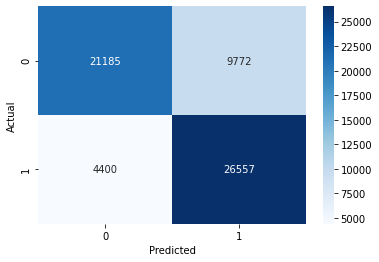



 Confusion Matrix: Test: 
 


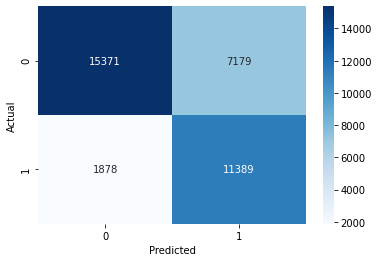



 AUC_ROC: Train: 
  0.8717494982283607
 AUC_ROC: Test: 
  0.8711648310655935


Classification Report: Train 
               precision    recall  f1-score   support

           0       0.83      0.68      0.75     30957
           1       0.73      0.86      0.79     30957

    accuracy                           0.77     61914
   macro avg       0.78      0.77      0.77     61914
weighted avg       0.78      0.77      0.77     61914

Classification Report: Test 
               precision    recall  f1-score   support

           0       0.89      0.68      0.77     22550
           1       0.61      0.86      0.72     13267

    accuracy                           0.75     35817
   macro avg       0.75      0.77      0.74     35817
weighted avg       0.79      0.75      0.75     35817



In [0]:
lr=LogisticRegression(random_state=20)
result_lr=modelEvaluation(lr,X_train,y_train,X_test,y_test,threshold = 0.4)

The intercept is [-0.62293124]


Text(0.5, 0, 'feature coefficient weights')

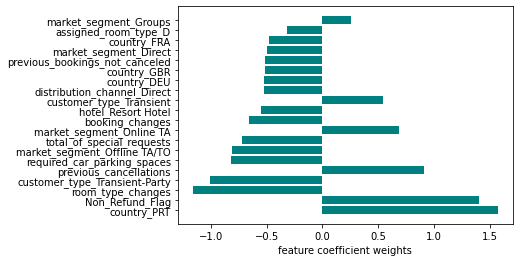

In [0]:
print("The intercept is",lr.intercept_)

weights_f = Series(lr.coef_[0],
                 index=X_train.columns.values)
weights_f2 = DataFrame(dict(weights = weights_f, weights_abs = weights_f.abs()))
weights_f2 = weights_f2.sort_values(by='weights_abs',ascending=False)
weights_f2 = weights_f2.reset_index().rename(columns={'index': 'Features'})

# plot the feature weights
fig = plt.figure()
ax = plt.subplot(111)
ax.barh(weights_f2['Features'][:20], weights_f2['weights'][:20], color='teal')
ax.set_xlabel('feature coefficient weights')

### Decision Trees

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


 Confusion Matrix: Train: 
 


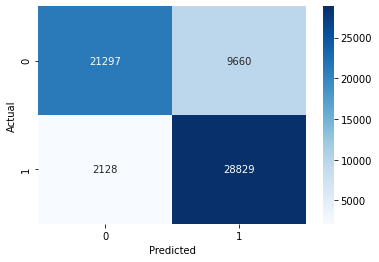



 Confusion Matrix: Test: 
 


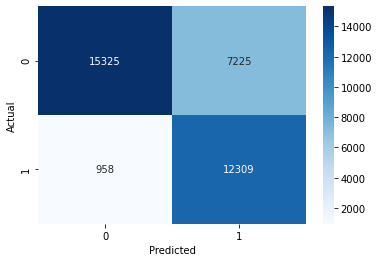



 AUC_ROC: Train: 
  0.9211885707095154
 AUC_ROC: Test: 
  0.9134681136213638


Classification Report: Train 
               precision    recall  f1-score   support

           0       0.91      0.69      0.78     30957
           1       0.75      0.93      0.83     30957

    accuracy                           0.81     61914
   macro avg       0.83      0.81      0.81     61914
weighted avg       0.83      0.81      0.81     61914

Classification Report: Test 
               precision    recall  f1-score   support

           0       0.94      0.68      0.79     22550
           1       0.63      0.93      0.75     13267

    accuracy                           0.77     35817
   macro avg       0.79      0.80      0.77     35817
weighted avg       0.83      0.77      0.77     35817



In [0]:
dtc=DecisionTreeClassifier(max_depth=10)
modelEvaluation(dtc,X_train,y_train,X_test,y_test,threshold=0.4)

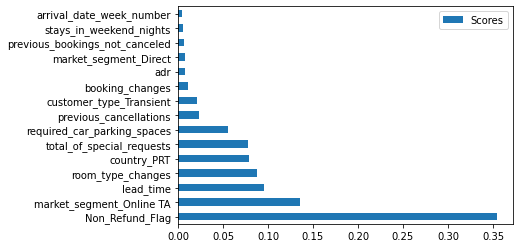

In [0]:
#Feature Importance
pd.DataFrame(index=X_train.columns,data=dtc.feature_importances_,columns=["Scores"]).sort_values("Scores",ascending=False)[:15].plot.barh()

### Random Forest

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=20, verbose=0,
                       warm_start=False)


 Confusion Matrix: Train: 
 


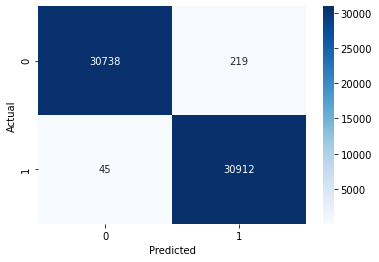



 Confusion Matrix: Test: 
 


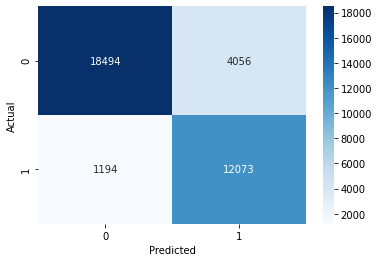



 AUC_ROC: Train: 
  0.9997238770726609
 AUC_ROC: Test: 
  0.9488101547995067


Classification Report: Train 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     30957
           1       0.99      1.00      1.00     30957

    accuracy                           1.00     61914
   macro avg       1.00      1.00      1.00     61914
weighted avg       1.00      1.00      1.00     61914

Classification Report: Test 
               precision    recall  f1-score   support

           0       0.94      0.82      0.88     22550
           1       0.75      0.91      0.82     13267

    accuracy                           0.85     35817
   macro avg       0.84      0.87      0.85     35817
weighted avg       0.87      0.85      0.86     35817



In [0]:
# print('Model: Random Forest\n')
rf = RandomForestClassifier(random_state=20)
modelEvaluation(rf,X_train,y_train,X_test,y_test,threshold=0.4)

### Random Forest Model Tuning

In [0]:
rf_parameters = {"max_depth": [10,13],
                 "n_estimators": [10,100,500],
                 "min_samples_split": [2,5]}
                 
rf_model = RandomForestClassifier()
rf_cv_model = GridSearchCV(rf_model,
                           rf_parameters,
                           cv = 3)
rf_cv_model.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [0]:
print('Best parameters: ' + str(rf_cv_model.best_params_))

Best parameters: {'max_depth': 13, 'min_samples_split': 2, 'n_estimators': 100}


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


 Confusion Matrix: Train: 
 


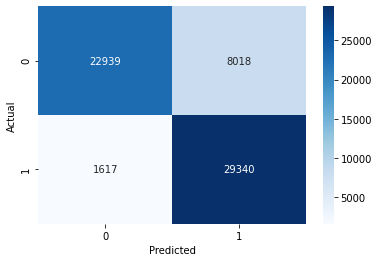



 Confusion Matrix: Test: 
 


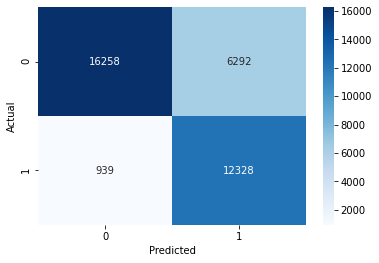



 AUC_ROC: Train: 
  0.9458894383904028
 AUC_ROC: Test: 
  0.932278940277771


Classification Report: Train 
               precision    recall  f1-score   support

           0       0.93      0.74      0.83     30957
           1       0.79      0.95      0.86     30957

    accuracy                           0.84     61914
   macro avg       0.86      0.84      0.84     61914
weighted avg       0.86      0.84      0.84     61914

Classification Report: Test 
               precision    recall  f1-score   support

           0       0.95      0.72      0.82     22550
           1       0.66      0.93      0.77     13267

    accuracy                           0.80     35817
   macro avg       0.80      0.83      0.80     35817
weighted avg       0.84      0.80      0.80     35817



In [0]:
rf_tuned = RandomForestClassifier(max_depth = 13,
                                  min_samples_split = 2,
                                  n_estimators = 500)

result_rf_tuned=modelEvaluation(rf_tuned,X_train,y_train,X_test,y_test,threshold=0.4)

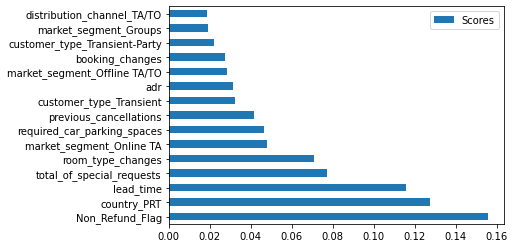

In [0]:
#Feature importances
pd.DataFrame(index=X_train.columns,data=rf_tuned.feature_importances_,columns=["Scores"]).sort_values("Scores",ascending=False)[:15].plot.barh()

### CatBoost

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))



 Confusion Matrix: Train: 
 


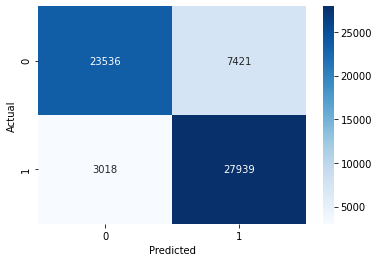



 Confusion Matrix: Test: 
 


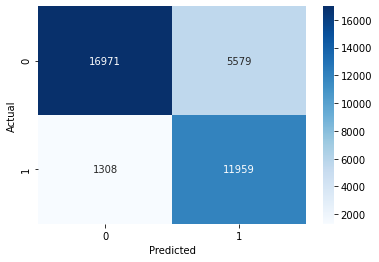



 AUC_ROC: Train: 
  0.9273394613457688
 AUC_ROC: Test: 
  0.9248336527439087


Classification Report: Train 
               precision    recall  f1-score   support

           0       0.89      0.76      0.82     30957
           1       0.79      0.90      0.84     30957

    accuracy                           0.83     61914
   macro avg       0.84      0.83      0.83     61914
weighted avg       0.84      0.83      0.83     61914

Classification Report: Test 
               precision    recall  f1-score   support

           0       0.93      0.75      0.83     22550
           1       0.68      0.90      0.78     13267

    accuracy                           0.81     35817
   macro avg       0.81      0.83      0.80     35817
weighted avg       0.84      0.81      0.81     35817



In [0]:
catboost = CatBoostClassifier(iterations =500,use_best_model=True,max_depth=2,od_type='Iter',custom_loss='F1')
result_catboost=modelEvaluation(catboost,X_train,y_train,X_test,y_test,threshold=0.4)

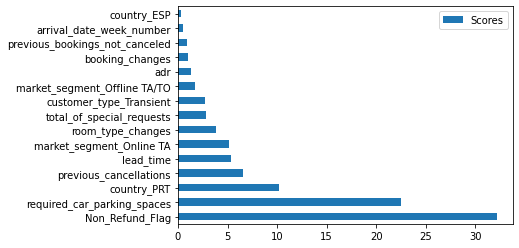

In [0]:
#Feature importances
pd.DataFrame(index=X_train.columns,data=catboost.feature_importances_,columns=["Scores"]).sort_values("Scores",ascending=False)[:15].plot.barh()

The Random forest model is the best on recall score and we used its' predictions to further calculate the expected actual demand for the time period. This work has been shown in the attached excel file.